In [4]:
import torch
import triton
import triton.language as tl

def pack_float16(mans, exp):
    out = (mans / 1024.0) * exp.exp2()
    return out.to(torch.float16)


def naive_msb(man, exp, bit):
    ones = torch.ones_like(man)
    msb = torch.zeros_like(exp)
    for i in range(1, bit):
        mask = ones << (i - 1)
        msb.masked_fill_((man & mask) != 0, i)
    return msb


def normalization_hmfp(man, exp, bit, output_format=(5, 12)):
    bit = int(bit)
    e, m = output_format
    assert man.dtype in [torch.int8, torch.int16, torch.int32, torch.int64]
    assert exp.dtype in [torch.int8, torch.int16]
    assert e > 0 and e <= 16
    assert m > 4 and m <= 64

    # fast return
    if man.min() >= -pow(2, m - 1) and man.max() < pow(2, m - 1):
        return pack_float16(man, exp)

    sign = man >= 0
    neg = man.abs()
    neg.sub_(1).clip_(min=2)
    tmp = torch.where(sign, man, neg)

    msb = naive_msb(tmp, exp, bit)

    shift = msb.sub(m - 1).clip_(min=0)
    man_ = man >> shift
    exp = exp.add(shift)

    # assert man_.min() >= -pow(2, m-1) and man_.max() < pow(2, m-1)
    # assert exp.min() >= -pow(2, e-1) and exp.max() < pow(2, e-1)
    return pack_float16(man_, exp)


def float16_mul(a, b, input_format=(5, 12), output_format=(5, 12)):
    a_int = a.view(torch.int16)
    b_int = b.view(torch.int16)

    # 提取符号、指数和尾数
    sign_mask = 0x8000
    exp_mask = 0x7C00
    mantissa_mask = 0x03FF

    a_sign = (a_int & sign_mask) >> 15
    a_sign = torch.where(a_sign == 0, 1, -1)

    b_sign = (b_int & sign_mask) >> 15
    b_sign = torch.where(b_sign == 0, 1, -1)

    a_exp = (a_int & exp_mask) >> 10
    b_exp = (b_int & exp_mask) >> 10

    a_mantissa = a_int & mantissa_mask
    a_mantissa = torch.where(
        a_exp != 0, a_mantissa.add(1024) * a_sign, a_mantissa * a_sign
    )

    b_mantissa = b_int & mantissa_mask
    b_mantissa = torch.where(
        b_exp != 0, b_mantissa.add(1024) * b_sign, b_mantissa * b_sign
    )

    a_exp = torch.where(a_exp != 0, a_exp - 15, a_exp - 15 + 1)
    b_exp = torch.where(b_exp != 0, b_exp - 15, b_exp - 15 + 1)
    exp = a_exp + b_exp
    shift = torch.tensor(10).exp2()
    out = (a_mantissa * b_mantissa).div(shift, rounding_mode="trunc").to(torch.int32)
    return normalization_hmfp(out, exp, bit=32, output_format=output_format)


def float16_add(a, b, input_format=(5, 12), output_format=(5, 12)):
    a_int = a.view(torch.int16)
    b_int = b.view(torch.int16)

    # 提取符号、指数和尾数
    sign_mask = 0x8000
    exp_mask = 0x7C00
    mantissa_mask = 0x03FF

    a_sign = (a_int & sign_mask) >> 15
    a_sign = torch.where(a_sign == 0, 1, -1)

    b_sign = (b_int & sign_mask) >> 15
    b_sign = torch.where(b_sign == 0, 1, -1)

    a_exp = (a_int & exp_mask) >> 10
    b_exp = (b_int & exp_mask) >> 10

    a_mantissa = a_int & mantissa_mask
    a_mantissa = torch.where(
        a_exp != 0, a_mantissa.add(1024) * a_sign, a_mantissa * a_sign
    )

    b_mantissa = b_int & mantissa_mask
    b_mantissa = torch.where(
        b_exp != 0, b_mantissa.add(1024) * b_sign, b_mantissa * b_sign
    )

    a_exp = torch.where(a_exp != 0, a_exp - 15, a_exp - 15 + 1)
    b_exp = torch.where(b_exp != 0, b_exp - 15, b_exp - 15 + 1)

    shift = torch.maximum(a_exp, b_exp) - torch.minimum(a_exp, b_exp)
    shift = shift.exp2()
    # 进行对齐指数  小的指数进行移位
    a_mantissa = torch.where(
        a_exp > b_exp, a_mantissa, a_mantissa.div(shift, rounding_mode="trunc")
    )
    b_mantissa = torch.where(
        a_exp > b_exp, b_mantissa.div(shift, rounding_mode="trunc"), b_mantissa
    )

    out = (a_mantissa + b_mantissa).to(torch.int16)
    return normalization_hmfp(
        out, torch.maximum(a_exp, b_exp), bit=32, output_format=output_format
    )

# 每个 kernel 处理的元素数
BLOCK_SIZE = 1024

@triton.jit
def float16_mul_kernel(a_ptr, b_ptr, out_ptr, n_elements: tl.constexpr, m: tl.constexpr, bit: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    """
    使用 Triton 实现 float16 乘法：
      - 以 int16 格式加载 a 和 b；
      - 提取符号、指数、尾数（对于非零指数，加上隐含1，即1024）；
      - 调整指数（非零时减15，否则减14）；
      - 计算乘法：指数相加，尾数相乘后除以 2^10；
      - 对乘积进行规格化：根据目标尾数位宽 m，通过逐位扫描（bit 循环）确定最高有效位，
        如果 msb 超出 m-1，则右移相应位数，并补偿指数；
      - 最后计算：(norm_mant/1024.0) * 2^(norm_exp) 并 cast 为 float16。
    """
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    # 加载 float16 数据（按 int16 处理）并扩展到 int32
    a_val = tl.cast(tl.load(a_ptr + offsets, mask=mask), tl.int32)
    b_val = tl.cast(tl.load(b_ptr + offsets, mask=mask), tl.int32)

    sign_mask = 0x8000
    exp_mask = 0x7C00
    mant_mask = 0x03FF

    # 提取符号：0 表示正数，非0 表示负数
    a_sign = tl.where((a_val & sign_mask) == 0, 1, -1)
    b_sign = tl.where((b_val & sign_mask) == 0, 1, -1)
    # 提取指数和尾数
    a_exp = (a_val & exp_mask) >> 10
    b_exp = (b_val & exp_mask) >> 10
    a_mant = a_val & mant_mask
    b_mant = b_val & mant_mask

    # 对于非零指数，加上隐含1（1024），同时乘上符号
    a_mant = tl.where(a_exp != 0, a_mant + 1024, a_mant) * a_sign
    b_mant = tl.where(b_exp != 0, b_mant + 1024, b_mant) * b_sign

    # 指数调整：非零时减15，否则减14（即补偿 denormal 数字）
    a_exp = tl.where(a_exp != 0, a_exp - 15, a_exp - 14)
    b_exp = tl.where(b_exp != 0, b_exp - 15, b_exp - 14)

    out_exp = a_exp + b_exp
    # 尾数乘法后除以 2^10，使用截断除法
    prod = (a_mant * b_mant) // 1024

    # 计算最终数值：(norm_mant/1024.0) * 2^(norm_exp)，并 cast 为 float16
    result = (tl.cast(prod, tl.float32) / 1024.0) * tl.exp2(tl.cast(out_exp, tl.float32))
    result = tl.cast(result, tl.float16)
    tl.store(out_ptr + offsets, result, mask=mask)

@triton.jit
def float16_add_kernel(a_ptr, b_ptr, out_ptr, n_elements: tl.constexpr, m: tl.constexpr, bit: tl.constexpr, BLOCK_SIZE: tl.constexpr):
    """
    使用 Triton 实现 float16 加法：
      - 以 int16 格式加载 a 和 b，提取符号、指数和尾数；
      - 对非零指数加上隐含1，调整指数（非零时减15，否则减14）；
      - 对齐指数：以较大指数为准，对较小尾数进行右移；
      - 将尾数相加，得到中间结果；
      - 规格化过程同乘法：逐位扫描确定最高有效位，必要时右移尾数并调整指数；
      - 最后计算最终值：(norm_mant/1024.0)*2^(norm_exp) 并 cast 为 float16。
    """
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    a_val = tl.cast(tl.load(a_ptr + offsets, mask=mask), tl.int32)
    b_val = tl.cast(tl.load(b_ptr + offsets, mask=mask), tl.int32)

    sign_mask = 0x8000
    exp_mask = 0x7C00
    mant_mask = 0x03FF

    a_sign = tl.where((a_val & sign_mask) == 0, 1, -1)
    b_sign = tl.where((b_val & sign_mask) == 0, 1, -1)
    a_exp = (a_val & exp_mask) >> 10
    b_exp = (b_val & exp_mask) >> 10
    a_mant = a_val & mant_mask
    b_mant = b_val & mant_mask

    a_mant = tl.where(a_exp != 0, a_mant + 1024, a_mant) * a_sign
    b_mant = tl.where(b_exp != 0, b_mant + 1024, b_mant) * b_sign

    a_exp = tl.where(a_exp != 0, a_exp - 15, a_exp - 14)
    b_exp = tl.where(b_exp != 0, b_exp - 15, b_exp - 14)

    # 对齐指数：以较大指数为准，对较小尾数右移补齐
    max_exp = tl.maximum(a_exp, b_exp)
    min_exp = tl.minimum(a_exp, b_exp)
    diff = max_exp - min_exp
    shift_val = tl.cast(tl.exp2(tl.cast(diff, tl.float32)), tl.int32)
    a_mant_aligned = tl.where(a_exp > b_exp, a_mant, a_mant // shift_val)
    b_mant_aligned = tl.where(a_exp > b_exp, b_mant // shift_val, b_mant)
    sum_mant = a_mant_aligned + b_mant_aligned
    out_exp = max_exp

    result = (tl.cast(sum_mant, tl.float32) / 1024.0) * tl.exp2(tl.cast(out_exp, tl.float32))
    result = tl.cast(result, tl.float16)
    tl.store(out_ptr + offsets, result, mask=mask)

# 封装 Host 侧调用接口
def float16_mul_triton(a: torch.Tensor, b: torch.Tensor, m: int = 12, bit: int = 32):
    """
    输入 a 和 b 均为 torch.float16 张量，返回乘法结果。
    """
    assert a.is_cuda and b.is_cuda, "输入张量必须在 GPU 上"
    n_elements = a.numel()
    out = torch.empty_like(a)
    grid = (triton.cdiv(n_elements, BLOCK_SIZE),)
    # 注意这里 view 为 int16 后传入 kernel，输出同样以 int16 view 存储，再转换回 float16
    float16_mul_kernel[grid](
        a.view(torch.int16), b.view(torch.int16), out, n_elements, m, bit, BLOCK_SIZE
    )
    return out

def float16_add_triton(a: torch.Tensor, b: torch.Tensor, m: int = 12, bit: int = 32):
    """
    输入 a 和 b 均为 torch.float16 张量，返回加法结果。
    """
    assert a.is_cuda and b.is_cuda, "输入张量必须在 GPU 上"
    n_elements = a.numel()
    out = torch.empty_like(a)
    grid = (triton.cdiv(n_elements, BLOCK_SIZE),)
    float16_add_kernel[grid](
        a.view(torch.int16), b.view(torch.int16), out, n_elements, m, bit, BLOCK_SIZE
    )
    return out

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='float16-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float16)
    y = torch.rand(size, device="cuda", dtype=torch.float16)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: float16_add(x, y), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: float16_add_triton(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

PyTorch mul result: tensor([ 1.0719e-03,  6.5369e-02,  5.8350e-01, -4.6992e+00,  9.1919e-02,
         5.0476e-02,  2.0020e+00, -7.3425e-02, -3.7109e-01,  6.8481e-02],
       device='cuda:0', dtype=torch.float16)
PyTorch add result: tensor([-0.4648, -0.8491,  1.5391,  0.7314,  0.6328,  1.2080,  2.8398, -1.2852,
        -0.7417,  0.5337], device='cuda:0', dtype=torch.float16)
Mul result: tensor([ 1.0719e-03,  6.5308e-02,  5.8301e-01, -4.6992e+00,  9.1919e-02,
         5.0476e-02,  2.0000e+00, -7.3364e-02, -3.7085e-01,  6.8481e-02],
       device='cuda:0', dtype=torch.float16)
Add result: tensor([-0.4648, -0.8491,  1.5391,  0.7324,  0.6328,  1.2080,  2.8398, -1.2852,
        -0.7422,  0.5337], device='cuda:0', dtype=torch.float16)


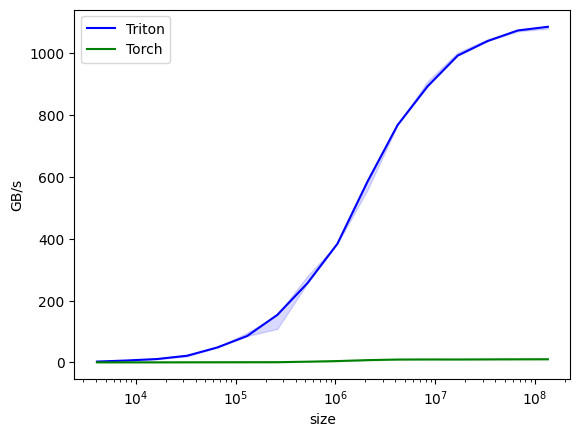

float16-add-performance:
           size       Triton     Torch
0        4096.0     2.400000  0.016535
1        8192.0     6.000000  0.026301
2       16384.0    10.666666  0.022819
3       32768.0    21.333333  0.130835
4       65536.0    48.000000  0.264281
5      131072.0    85.333330  0.379072
6      262144.0   153.600004  0.479251
7      524288.0   255.999991  2.059672
8     1048576.0   384.000001  4.060806
9     2097152.0   585.142862  7.127610
10    4194304.0   768.000002  9.002198
11    8388608.0   893.672720  9.313501
12   16777216.0   992.969726  9.198896
13   33554432.0  1040.253977  9.589465
14   67108864.0  1074.360676  9.867404
15  134217728.0  1086.232069  9.999517


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
a = torch.randn(4096, device='cuda', dtype=torch.float16)
b = torch.randn(4096, device='cuda', dtype=torch.float16)

# 使用 Triton 实现的乘法和加法
out_mul = float16_mul_triton(a, b)
out_add = float16_add_triton(a, b)

# 使用 PyTorch 实现的乘法和加法
out_mul_pytorch = a * b
out_add_pytorch = a + b

# 比较结果
print("PyTorch mul result:", out_mul_pytorch[:10])
print("PyTorch add result:", out_add_pytorch[:10])

print("Mul result:", out_mul[:10])
print("Add result:", out_add[:10])

benchmark.run(print_data=True, show_plots=True)